In [1]:
import numpy as np
import pandas as pd
import ecco_v4_py as ecco
import xarray as xr
from scipy.spatial import KDTree
from patchface3D import *
import swot_ssh_utils as swot
import sys
sys.path.append('/home/shoshi/MITgcm_c68p/MITgcm/utils/python/MITgcmutils')
from MITgcmutils import rdmds

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

### Read in Grid Data

In [2]:
sNx=30
sNy=30

grid_dir='/scratch/shoshi/MITgcm_c68p/llc90/run_obsfit_pk0000205956/'
hfc90 = rdmds(grid_dir+'hFacC', lev=0)
hfc90[hfc90!=0]=np.nan
# Convert to dict of 5 faces, sizes [(270,90), (270,90), (90,90), (90,270), (90,270)]
hfc90_faces = ecco.llc_compact_to_faces(hfc90, less_output=True)

xc = rdmds(grid_dir+'XC')
yc = rdmds(grid_dir+'YC')


### Read in SWOT Data

In [3]:
# load swot data
pth = '/home/shoshi/swot/'
filename = 'SWOT_L2_LR_SSH_Expert_576_021_20230708T231352_20230708T235844_PIB0_01.nc'

ds_swot = xr.open_dataset(pth + filename)
ds_swot = ds_swot.drop_dims('num_sides')
ds_swot['longitude'] = (ds_swot['longitude'] + 180) % 360 - 180
swot_coords = np.c_[ds_swot.latitude.values.ravel(), ds_swot.longitude.values.ravel()]

swot_coords



/home/shoshi/mambaforge/envs/py38/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/shoshi/mambaforge/envs/py38/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


array([[ -77.053978,   41.597367],
       [ -77.071893,   41.597158],
       [ -77.089808,   41.596949],
       ...,
       [  77.089942, -150.977398],
       [  77.072027, -150.977587],
       [  77.054112, -150.977775]])

In [4]:
# apply corrections
ssha = ds_swot.ssha_karin_2
flag = ds_swot.ancillary_surface_classification_flag
ssha = np.where(flag == 0, ssha, np.nan)

distance = ds_swot.cross_track_distance.values

ssha = swot.fit_bias(
        ssha, distance,
        check_bad_point_threshold=0.1,
        remove_along_track_polynomial=True
    )

ds_swot.ssha_karin_2.values = ssha

### Compute _interp fields

translated from /home/atnguyen/llc270/global/matlab/simple_ctd/

step02:
- xc and yc are reshaped from compact (nx, 13*nx) to worldmap (4*nx, 4*nx)
- prof_point/nearest_swot_index is computed relative to worldmap view
  
step04
- Line 43/44: xc and yc are turned from (4*nx, 4*nx) to 5-face view. Use patchface3D_wrld_to_5f. This is "direction 3" in matlab script patchface3D.m 
- FOR face = 1..5: Do the [X,Y]C[11,NINJ] routine
- Line 68: (I think — convince yourself) sneakily turn each [X,Y]C[11,NINJ] field from 5-face  to compact
- Line 69: Change each field from compact to worldmap (she has done so in her python function)
- Line 70: Use the prof_point (which was created relative to worldmap view) to grab the index from each field, which are now properly in worldmap view.

1
(90, 270, 1)
1
(90, 270, 1)
1
(90, 270, 1)
1
(90, 270, 1)


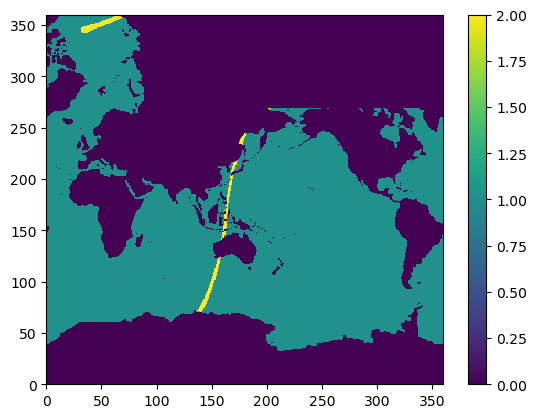

In [5]:
# step02:

# reshape xc, yc from compact (13*nx, nx) form to worldmap view (nz=1,4*nx, 4*nx)
nx = 90

xc = rdmds(grid_dir+'XC')
yc = rdmds(grid_dir+'YC')

xc = patchface3D(xc,nx,1)
yc = patchface3D(yc,nx,1)

llc_coords = np.c_[yc.ravel(), xc.ravel()]

# compute nearest_swot_index relative to worldmap view
kd_tree = KDTree(llc_coords)
distance, nearest_swot_index_in_llc = kd_tree.query(swot_coords, k=1)

# plot to check 
grid_dir='/scratch/shoshi/MITgcm_c68p/llc90/run_obsfit_pk0000205956/'
hfc90 = rdmds(grid_dir+'hFacC', lev=0)
hfc_wrl = patchface3D(hfc90, nx, 1)[0,:,:]
hfc_wrl.ravel()[nearest_swot_index_in_llc] = 2
plt.pcolor(hfc_wrl*patchface3D(hfc90, nx, 1)[0,:,:])
plt.colorbar()

In [6]:
### step 4 ###

# transform xc and yc from worldmap (4*nx, 4*nx) to 5-face view
tileCount=0

xgrid = patchface3D_wrld_to_5f(xc)
ygrid = patchface3D_wrld_to_5f(yc)

for i in range(1,6):
    xgrid[i] = np.squeeze(xgrid[i])
    ygrid[i] = np.squeeze(ygrid[i])

XC11=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
YC11=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
XCNINJ=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
YCNINJ=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
iTile=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
jTile=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
tileNo=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))

# FOR face = 1..5: Do the [X,Y]C[11,NINJ] routine
for key in xgrid.keys():
    face_XC = xgrid[key] 
    face_YC = ygrid[key]
    for ii in range(int(face_XC.shape[1]/sNx)):
        for jj in range(int(face_XC.shape[0]/sNy)):
            tileCount += 1
            tmp_i = np.arange(sNx)+sNx*ii
            tmp_j = np.arange(sNy)+sNx*jj
            tmp_XC = face_XC[ np.ix_( tmp_j, tmp_i ) ]
            tmp_YC = face_YC[ np.ix_( tmp_j, tmp_i ) ]
            XC11[key][ np.ix_( tmp_j, tmp_i ) ] = tmp_XC[0,0]
            YC11[key][ np.ix_( tmp_j, tmp_i ) ] = tmp_YC[0,0]
            XCNINJ[key][ np.ix_( tmp_j, tmp_i ) ] = tmp_XC[-1,-1]
            YCNINJ[key][ np.ix_( tmp_j, tmp_i ) ] = tmp_YC[-1,-1]
            iTile[key][ np.ix_( tmp_j, tmp_i ) ] = np.ones((sNx,1)) * np.arange(1,sNy+1)
            jTile[key][ np.ix_( tmp_j, tmp_i ) ] = (np.arange(1,sNx+1) * np.ones((sNy,1))).T
            tileNo[key][ np.ix_( tmp_j, tmp_i ) ] = tileCount*np.ones((sNy,sNx))




In [7]:
tile_keys = ['XC11', 'YC11', 'XCNINJ', 'YCNINJ', 'i', 'j']
tile_vals = [XC11, YC11, XCNINJ, YCNINJ, iTile, jTile]
tile_data_in = dict(zip(tile_keys, tile_vals))
tile_dict = dict()
for key in tile_keys:

    # - Line 68: sneakily turn each [X,Y]C[11,NINJ] field from 5-face  to compact
    temp = tile_data_in[key]
    temp = np.concatenate((temp[1], temp[2], temp[3], temp[4].T, temp[5].T))

    # - Line 69: Change each field from compact to worldmap (she has done so in her python function)
    tile_data_in[key] = patchface3D(temp,nx,1)

    # - Line 70: Use the obs_point (which was created relative to worldmap view) to grab the index from each field, 
    # which are now properly in worldmap view.
    tile_dict['sample_interp_' + key] = tile_data_in[key].ravel()[nearest_swot_index_in_llc]

1
(90, 270, 1)
1
(90, 270, 1)
1
(90, 270, 1)
1
(90, 270, 1)
1
(90, 270, 1)
1
(90, 270, 1)


In [8]:
tile_dict['sample_interp_XC11'].shape, tile_dict

((680754,),
 {'sample_interp_XC11': array([ 22.5       ,  22.5       ,  22.5       , ..., 143.94377136,
         143.94377136, 143.94377136]),
  'sample_interp_YC11': array([-69.8248291 , -69.8248291 , -69.8248291 , ...,  82.11170959,
          82.11170959,  82.11170959]),
  'sample_interp_XCNINJ': array([  51.5       ,   51.5       ,   51.5       , ..., -154.91578674,
         -154.91578674, -154.91578674]),
  'sample_interp_YCNINJ': array([-57.27140808, -57.27140808, -57.27140808, ...,  71.59686279,
          71.59686279,  71.59686279]),
  'sample_interp_i': array([20., 20., 20., ..., 16., 16., 16.]),
  'sample_interp_j': array([ 1.,  1.,  1., ..., 28., 28., 28.])})

### Add obs_interp_ fields to data

In [9]:
# reshape for num_lines, num_pixels
for key in tile_dict.keys():
    tile_dict[key] = tile_dict[key].reshape(ds_swot.ssh_karin_2.shape)

# add interp fields to xarray
for key, item in tile_dict.items():
    dims = ('num_lines', 'num_pixels')  # Replace with your actual dimension names
    var_da = xr.DataArray(item, dims=dims, name=key)
    ds_swot[key] = var_da

In [10]:
# up until this point, we have obsfit fields for each individual swot point
# now can group and average all swot ssha values in same llc grid square

df_swot = ds_swot.to_dataframe()
gb = df_swot.groupby(['sample_interp_XC11', 'sample_interp_YC11', 'sample_interp_XCNINJ', 'sample_interp_YCNINJ', 'sample_interp_i', 'sample_interp_j'])
counts = gb.size().to_frame(name='counts')
gb_stats = (counts
.join(gb.agg({'ssha_karin_2': 'mean'}).rename(columns={'ssha_karin_2': 'obs_val'}))
.join(gb.agg({'ssha_karin_2': 'std'}).rename(columns={'ssha_karin_2': 'ssha_karin_2_std'}))
.join(gb.agg({'latitude': 'mean'}).rename(columns={'latitude': 'sample_x'}))
.join(gb.agg({'latitude': 'std'}).rename(columns={'latitude': 'latitude_std'}))
.join(gb.agg({'longitude': 'mean'}).rename(columns={'longitude': 'sample_y'}))
.join(gb.agg({'longitude': 'std'}).rename(columns={'longitude': 'longitude_std'}))
.join(gb.agg({'time': 'mean'}).rename(columns={'time': 'time_mean'}))
#.join(gb.agg({'time': 'std'}).rename(columns={'time': 'time_std'}))
.reset_index()
)

gb_stats

/home/shoshi/mambaforge/envs/py38/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/shoshi/mambaforge/envs/py38/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


,sample_interp_XC11,sample_interp_YC11,sample_interp_XCNINJ,sample_interp_YCNINJ,sample_interp_i,sample_interp_j,counts,obs_val,ssha_karin_2_std,sample_x,latitude_std,sample_y,longitude_std,time_mean
0,22.500000,-69.824829,51.500000,-57.271408,20.0,1.0,355,NaN,NaN,-77.648201,0.363053,41.764347,0.123760,NaT
1,22.500000,-69.824829,51.500000,-57.271408,21.0,1.0,845,NaN,NaN,-77.656138,0.355942,42.492342,0.296379,NaT
2,22.500000,-69.824829,51.500000,-57.271408,22.0,1.0,818,NaN,NaN,-77.645837,0.354852,43.502007,0.286670,NaT
3,22.500000,-69.824829,51.500000,-57.271408,23.0,1.0,827,NaN,NaN,-77.638070,0.357826,44.499477,0.289515,NaT
4,22.500000,-69.824829,51.500000,-57.271408,24.0,1.0,827,NaN,NaN,-77.626019,0.358011,45.500782,0.288930,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,143.943771,82.111710,-154.915787,71.596863,26.0,4.0,129,0.392279,0.072412,73.813807,0.094772,171.528819,0.177578,2023-07-08 23:56:36.884802816
962,143.943771,82.111710,-154.915787,71.596863,26.0,5.0,20,0.434416,0.024889,74.039974,0.038183,172.936366,0.072678,2023-07-08 23:56:44.660031488
963,143.943771,82.111710,-154.915787,71.596863,27.0,1.0,250,0.448949,0.101966,73.014214,0.139225,167.953381,0.227518,2023-07-08 23:56:14.365158912
964,143.943771,82.111710,-154.915787,71.596863,27.0,2.0,77,0.493010,0.088182,73.269531,0.072146,169.291182,0.138693,2023-07-08 23:56:22.371382272


### verify new interpolation gives similar results to old method

In [13]:
gb_stats_old = pd.read_csv('gb_stats_old.csv')
gb_stats_old

gb_stats = gb_stats[~np.isnan(gb_stats['obs_val'])]
gb_stats_old = gb_stats_old[~np.isnan(gb_stats_old['ssha_karin_2_mean'])]

tmp = np.sort(gb_stats_old.latitude.values) - np.sort(gb_stats.sample_y.values)
np.nanmin(tmp), np.nanmax(tmp)
np.unique(np.unique(gb_stats.obs_val) - np.unique(gb_stats_old.ssha_karin_2_mean), return_counts=True)

(array([-9.71445147e-17, -9.54097912e-17, -9.10729825e-17, -9.02056208e-17,
        -8.67361738e-17, -8.50014503e-17, -8.32667268e-17, -8.15320034e-17,
        -7.97972799e-17, -7.63278329e-17, -7.45931095e-17, -7.28583860e-17,
        -7.19910243e-17, -6.93889390e-17, -6.24500451e-17, -5.58906220e-17,
        -5.55111512e-17, -5.37764278e-17, -4.85722573e-17, -4.51028104e-17,
        -4.33680869e-17, -4.25007252e-17, -4.16333634e-17, -3.46944695e-17,
        -3.12250226e-17, -2.90566182e-17, -2.77555756e-17, -2.08166817e-17,
        -1.77809156e-17, -1.43114687e-17, -1.38777878e-17, -1.04083409e-17,
        -7.80625564e-18, -6.93889390e-18, -3.46944695e-18, -1.73472348e-18,
         0.00000000e+00,  3.46944695e-18,  6.93889390e-18,  1.38777878e-17,
         1.73472348e-17,  2.08166817e-17,  2.25514052e-17,  2.39608680e-17,
         2.42861287e-17,  2.77555756e-17,  3.46944695e-17,  3.88144378e-17,
         4.11996826e-17,  4.16333634e-17,  4.33680869e-17,  4.51028104e-17,
         4.8

## Create obsfit xarray

In [22]:
from datetime import datetime as dt

def datenum(d):
    return 366 + d.toordinal() + (d - dt.fromordinal(d.toordinal())).total_seconds()/(24*60*60)

d = dt.strptime('2023-07-08 23:14:16.622514','%Y-%m-%d %H:%M:%S.%f')
dn = datenum(d)
d, dn

(datetime.datetime(2023, 7, 8, 23, 14, 16, 622514), 739075.9682479458)

In [29]:
df_swot

time time_tai   latitude   longitude  ssh_karin  \
num_lines num_pixels                                                   
0         0           NaT      NaT -77.053978   41.597367        NaN   
          1           NaT      NaT -77.071893   41.597158        NaN   
          2           NaT      NaT -77.089808   41.596949        NaN   
          3           NaT      NaT -77.107723   41.596738        NaN   
          4           NaT      NaT -77.125638   41.596528        NaN   
...                   ...      ...        ...         ...        ...   
9865      64          NaT      NaT  77.125772 -150.977018        NaN   
          65          NaT      NaT  77.107857 -150.977208        NaN   
          66          NaT      NaT  77.089942 -150.977398        NaN   
          67          NaT      NaT  77.072027 -150.977587        NaN   
          68          NaT      NaT  77.054112 -150.977775        NaN   

                      ssh_karin_qual  ssh_karin_uncert  ssha_karin  \
num_lines num_pixels                                                 
0         0             4.160783e+09               NaN         NaN   
          1             4.160783e+09               NaN         NaN   
          2             4.160783e+09               NaN         NaN   
          3             4.160783e+09               NaN         NaN   
          4             4.160783e+09               NaN         NaN   
...                              ...               ...         ...   
9865      64            4.160783e+09               NaN         NaN   
          65            4.160783e+09               NaN         NaN   
          66            4.160783e+09               NaN         NaN   
          67            4.160783e+09               NaN         NaN   
          68            4.160783e+09               NaN         NaN   

                      ssha_karin_qual  ssh_karin_2  ...  swh_ssb_cor_source  \
num_lines num_pixels                                ...                       
0         0              4.227891e+09          NaN  ...                 0.0   
          1              4.227891e+09          NaN  ...                 0.0   
          2              4.227891e+09          NaN  ...                 0.0   
          3              4.227891e+09          NaN  ...                 0.0   
          4              4.227891e+09          NaN  ...                 0.0   
...                               ...          ...  ...                 ...   
9865      64             4.227891e+09          NaN  ...                 0.0   
          65             4.227891e+09          NaN  ...                 0.0   
          66             4.227891e+09          NaN  ...                 0.0   
          67             4.227891e+09          NaN  ...                 0.0   
          68             4.227891e+09          NaN  ...                 0.0   

                      swh_ssb_cor_source_2  wind_speed_ssb_cor_source  \
num_lines num_pixels                                                    
0         0                            0.0                        0.0   
          1                            0.0                        0.0   
          2                            0.0                        0.0   
          3                            0.0                        0.0   
          4                            0.0                        0.0   
...                                    ...                        ...   
9865      64                           0.0                        0.0   
          65                           0.0                        0.0   
          66                           0.0                        0.0   
          67                           0.0                        0.0   
          68                           0.0                        0.0   

                      wind_speed_ssb_cor_source_2  sample_interp_XC11  \
num_lines num_pixels                                                    
0         0                                   0.0

In [32]:
gb_stats = gb_stats[~np.isnan(gb_stats['obs_val'])]

gb_stats['obs_date'] = pd.to_datetime(gb_stats['time_mean']).apply(lambda x: datenum(x))
gb_stats['obs_YYYYMMDD'] = gb_stats['time_mean'].apply(lambda x: int(x.strftime('%Y%m%d')))
gb_stats['obs_HHMMSS'] = gb_stats['time_mean'].apply(lambda x: int(x.strftime('%H%M%S')))

gb_stats

,sample_interp_XC11,sample_interp_YC11,sample_interp_XCNINJ,sample_interp_YCNINJ,sample_interp_i,sample_interp_j,counts,obs_val,ssha_karin_2_std,sample_x,latitude_std,sample_y,longitude_std,time_mean,obs_date,obs_YYYYMMDD,obs_HHMMSS
99,82.500000,-69.824829,111.500000,-57.271408,18.0,12.0,229,0.270322,0.244007,-65.711956,0.108187,99.743742,0.174272,2023-07-08 23:14:16.622514432,739075.968248,20230708,231416
106,82.500000,-69.824829,111.500000,-57.271408,19.0,12.0,524,0.078896,0.276075,-65.665488,0.117639,100.499320,0.290072,2023-07-08 23:14:20.097690112,739075.968288,20230708,231420
107,82.500000,-69.824829,111.500000,-57.271408,19.0,13.0,445,0.088349,0.128418,-65.276906,0.115668,100.571651,0.260192,2023-07-08 23:14:26.196760832,739075.968359,20230708,231426
108,82.500000,-69.824829,111.500000,-57.271408,19.0,14.0,148,0.157740,0.060179,-64.915536,0.095805,100.814916,0.131797,2023-07-08 23:14:32.533022464,739075.968432,20230708,231432
113,82.500000,-69.824829,111.500000,-57.271408,20.0,12.0,523,0.466956,0.142539,-65.664992,0.117853,101.500950,0.289294,2023-07-08 23:14:23.708534272,739075.968330,20230708,231423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,143.943771,82.111710,-154.915787,71.596863,26.0,3.0,310,0.394841,0.124699,73.577840,0.154168,170.140573,0.253643,2023-07-08 23:56:29.028369408,739075.997558,20230708,235629
961,143.943771,82.111710,-154.915787,71.596863,26.0,4.0,129,0.392279,0.072412,73.813807,0.094772,171.528819,0.177578,2023-07-08 23:56:36.884802816,739075.997649,20230708,235636
962,143.943771,82.111710,-154.915787,71.596863,26.0,5.0,20,0.434416,0.024889,74.039974,0.038183,172.936366,0.072678,2023-07-08 23:56:44.660031488,739075.997739,20230708,235644
963,143.943771,82.111710,-154.915787,71.596863,27.0,1.0,250,0.448949,0.101966,73.014214,0.139225,167.953381,0.227518,2023-07-08 23:56:14.365158912,739075.997388,20230708,235614


In [65]:
obs = xr.Dataset(
    data_vars=dict(
        obs_date           =(["iOBS"], gb_stats.obs_date.values),
        obs_YYYYMMDD       =(["iOBS"], gb_stats.obs_YYYYMMDD.values),
        obs_HHMMSS         =(["iOBS"], gb_stats.obs_HHMMSS.values), 
        sample_x           =(["iSAMPLE"], gb_stats.sample_x.values),
        sample_y           =(["iSAMPLE"], gb_stats.sample_y.values),
        sample_z           =(["iSAMPLE"], np.zeros(len(gb_stats.sample_y.values))),
        sample_type        =(["iSAMPLE"], 5*np.ones(len(gb_stats.sample_y.values))),
        obs_val            =(["iOBS"], gb_stats.obs_val.values),
        obs_weight         =(["iOBS"], np.ones(len(gb_stats.sample_y.values))),
        sample_interp_XC11 =(["iOBS"], gb_stats.sample_interp_XC11.values ),
        sample_interp_YC11 =(["iOBS"], gb_stats.sample_interp_YC11.values ),
        sample_interp_XCNINJ =(["iOBS"], gb_stats.sample_interp_XCNINJ.values ),
        sample_interp_YCNINJ =(["iOBS"], gb_stats.sample_interp_YCNINJ.values ),
        sample_interp_i =(["iOBS"], gb_stats.sample_interp_i.values ),
        sample_interp_j =(["iOBS"], gb_stats.sample_interp_j.values ),
        sample_interp_w =(["iOBS", "iINTERP"], np.ones((len(gb_stats.sample_interp_i),8))/8  )
    ),
)

In [61]:
obs = obs.assign_coords({'longitude': obs.sample_x, 'latitude': obs.sample_y})
obs

<xarray.Dataset>
Dimensions:               (iOBS: 560, iSAMPLE: 560, iINTERP: 8)
Coordinates:
    longitude             (iOBS) float64 -65.71 -65.67 -65.28 ... 73.01 73.27
    latitude              (iOBS) float64 99.74 100.5 100.6 ... 172.9 168.0 169.3
Dimensions without coordinates: iOBS, iSAMPLE, iINTERP
Data variables: (12/16)
    obs_date              (iOBS) float64 7.391e+05 7.391e+05 ... 7.391e+05
    obs_YYYYMMDD          (iOBS) int64 20230708 20230708 ... 20230708 20230708
    obs_HHMMSS            (iOBS) int64 231416 231420 231426 ... 235614 235622
    sample_x              (iOBS) float64 -65.71 -65.67 -65.28 ... 73.01 73.27
    sample_y              (iOBS) float64 99.74 100.5 100.6 ... 172.9 168.0 169.3
    sample_z              (iSAMPLE) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                    ...
    sample_interp_YC11    (iOBS) float64 -69.82 -69.82 -69.82 ... 82.11 82.11
    sample_interp_XCNINJ  (iOBS) float64 111.5 111.5 111.5 ... -154.9 -154.9
    sample_interp_YCNINJ  (iOBS) float64 -57.27 -57.27 -57.27 ... 71.6 71.6 71.6
    sample_interp_i       (iOBS) float64 18.0 19.0 19.0 19.0 ... 26.0 27.0 27.0
    sample_interp_j       (iOBS) float64 12.0 12.0 13.0 14.0 ... 4.0 5.0 1.0 2.0
    sample_interp_w       (iOBS, iINTERP) float64 0.125 0.125 ... 0.125 0.125

In [24]:
# data_dir = ''
# fname = filename.split('.')[0] + '_obsfit.nc'
# obs.to_netcdf(data_dir + fname)


'SWOT_L2_LR_SSH_Expert_576_021_20230708T231352_20230708T235844_PIB0_01_obsfit.nc'

Text(0.5, 1.0, 'SWOT SSH')

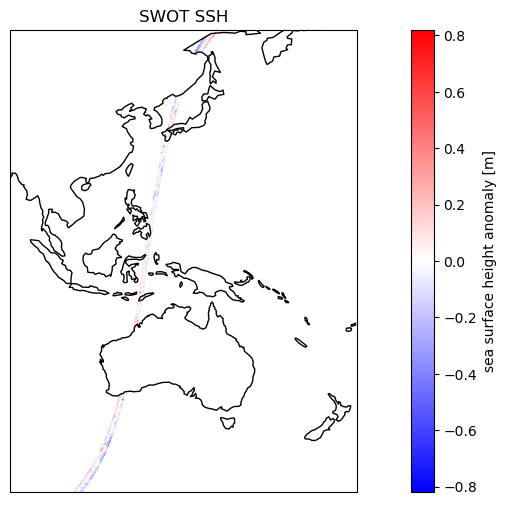

In [49]:
import cartopy.crs as ccrs

plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds_swot.ssha_karin_2.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude", cmap='bwr',add_colorbar=True
)
ax.coastlines()
ax.set_ylim([-60, 60])
ax.set_xlim([90,180])
plt.title('SWOT SSH')